# Telecom Client Churn Prediction

We are working at Telecom operator called Interconnect, and they would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

**GOAL:**
- Analysis the behaviour and character of the clients who left.
- Predict the clients will leave or stay by machine learning.

**Interconnect's services:**

Interconnect mainly provides two types of services:
- Landline communication. The telephone can be connected to several lines simultaneously.
- Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

**Some other services the company provides include:**
- Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
- A dedicated technical support line (TechSupport)
- Cloud file storage and data backup (OnlineBackup)
- TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.


# Table of Contents:

1. General Info
2. Data Preprocessing
3. EDA
4. Analysis
5. Model Training
6. Conclusion

## GENERAL INFO

**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer



**Loading Data**

We would like to load the data and see the information there.

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

**Checking The Information**

In [3]:
#See 5 data first
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
#See the type of data and check the lost value (if there)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
#Check the duplicated data
contract.duplicated().sum()

0

From the info above, we find that the type of column 'BeginDate' and 'EndDate' need to convert to date-time. Column 'Type', 'PaperlessBilling', and 'PaymentMethod' need to convert to category. Column 'MonthlyCharges' and 'TotalCharges' keep on float type.

In [6]:
#Check data personal
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
#Check the duplicated
personal.duplicated().sum()

0

From the information above we know that column 'SeniorCitizen' has type int64. All columns, except 'customerID' must be converted to categorical.

In [9]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
internet.duplicated().sum()

0

From the information above we find that the type of the columns must be converted to categorical type except 'customerID'. Then you can see that the amount the rows is less instead of the others. You could see the the rows is only 5517, it means not all the clients subscribed to the Internet service.

In [12]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
phone.duplicated().sum()

0

From the information above we could say that the type of column 'MultipleLines' must be changed to categorical type. The number of rows also less than other data ( personal and contract).

## Data Preprocessing

### Contract

In [15]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [16]:
#Convert the type of data
contract['Type'] = contract['Type'].astype('category')
contract['PaperlessBilling'] = contract['PaperlessBilling'].astype('category')
contract['PaymentMethod'] = contract['PaymentMethod'].astype('category')

#There is column 'TotalCharges' which has string stype
contract['TotalCharges']=pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

Now, we create the new column to detect the clients who didn't leave. If the column 'EndDate' filled by **No**, it means the clients haven't leave. The new column 'churn' contains 0 (haven't left) and 1 (already left).

In [17]:
#Create the new column to detect the client (haven't leave or already leave)
contract['churn'] = (contract['EndDate'] != "No").astype("int")
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [18]:
#Check the column 'TotalCharges' which has NaN value
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,0


The column 'EndDate' must be filled by date, but in fact, our data doesn't have the date, so if the data contains NO, we have to replace by the date (1 February 2020) because it was the date of our data has been taken. We follow the format of YYYY-MM-DD.

In [19]:
contract['EndDate']=contract['EndDate'].replace('No','2020-02-01 00:00:00')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
0,7590-VHVEG,2020-01-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01 00:00:00,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01 00:00:00,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [20]:
#Convert to date-time
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S')

In [21]:
#Check the info of our data type
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   churn             7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 351.3+ KB


Now, we have to create a column contains the amount of the day until 1 February 2020.

In [22]:
contract['days'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [23]:
#Drop the NaN value
contract.dropna(inplace=True)

In [24]:
#Check the info
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   category      
 4   PaperlessBilling  7032 non-null   category      
 5   PaymentMethod     7032 non-null   category      
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   churn             7032 non-null   int64         
 9   days              7032 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 460.6+ KB


From the preprocessing column 'Contract' we got amount of rows 7032.

### Personal

In [25]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [26]:
#Change to categorical data
personal['gender'] = personal['gender'].astype('category')
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('category')
personal['Partner'] = personal['Partner'].astype('category')
personal['Dependents'] = personal['Dependents'].astype('category')

In [27]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   category
 3   Partner        7043 non-null   category
 4   Dependents     7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.1+ KB


We have successed doing preprocessing the personal data.

**Merging Contract and Personal**

In [28]:
merge_1 = pd.merge(personal, contract, how='left', on='customerID')
merge_1.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days
347,8966-SNIZF,Female,0,Yes,No,2014-04-01,2020-02-01,Two year,No,Bank transfer (automatic),19.45,1303.50,0.0,2132.0
4184,0495-ZBNGW,Male,1,Yes,No,2019-05-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),79.90,343.95,1.0,153.0
6202,8559-CIZFV,Male,0,Yes,Yes,2018-03-01,2019-12-01,One year,No,Mailed check,77.50,1625.00,1.0,640.0
6290,2530-ENDWQ,Female,0,Yes,No,2013-12-01,2019-11-01,Two year,Yes,Bank transfer (automatic),93.70,6585.35,1.0,2161.0
2285,4307-KTUMW,Male,0,Yes,No,2015-05-01,2019-10-01,Month-to-month,No,Electronic check,93.90,5029.20,1.0,1614.0


**Drop the useless column**

In [29]:
merge_1 = merge_1.drop(['BeginDate','EndDate'], axis=1)

**Drop the NaN value**

In [30]:
merge_1.dropna(inplace=True)
merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   float64 
 11  days              7032 non-null   float64 
dtypes: category(7), float64(4), object(1)
memory usage: 378.6+ KB


### Phone

**Merging Phone and Merge_1**

In [31]:
merge_2 = pd.merge(merge_1, phone, how='left', on='customerID')
merge_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,NaN
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,NaN
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No


In [32]:
merge_2['MultipleLines'] = merge_2['MultipleLines'].fillna('No')

In [33]:
#Change to categorical data
merge_2['MultipleLines'] = merge_2['MultipleLines'].astype('category')

We have successed for merging the data.

### Internet

**Merging Internet and Merge_2**

In [34]:
data_final = pd.merge(merge_2, internet, how='left', on='customerID')
data_final.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No,Fiber optic,No,No,No,No,No,No


Now, we have to replace the **NaN** by **No**.

In [35]:
col_object = data_final.columns[data_final.dtypes=='object']
data_final[col_object] = data_final[col_object].fillna('No')

In [36]:
data_final.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No,Fiber optic,No,No,No,No,No,No


In [37]:
#Change to categorical data
object_cols = data_final.columns[data_final.dtypes == 'object'].difference(['customerID'])
data_final[object_cols] = data_final[object_cols].astype('category')

In [38]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   float64 
 11  days              7032 non-null   float64 
 12  MultipleLines     7032 non-null   category
 13  InternetService   7032 non-null   category
 14  OnlineSecurity    7032 non-null   category
 15  OnlineBackup      7032 non-null   category
 16  DeviceProtection  7032 n

We have processed our data.

## EDA (Eksploratory Data Analysis)

We would like to check the imbalance of the class.

**Imbalance Class**

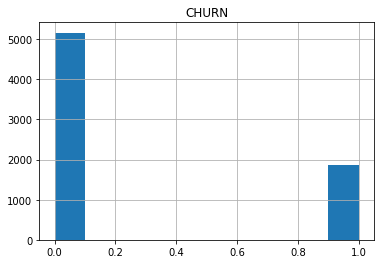

In [39]:
data_final['churn'].hist()
plt.title('CHURN')
plt.show()

From the histogram above, over 5000 clients still using (stayed) and a bit less than 2000 clients left.

**Features VS Churn Histogram**

In [40]:
#Making function to create a histogram
def plot_churn_distribution(data, churn_column, exclude_cols=None):
    exclude_cols = exclude_cols or []
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols)

    num_plots = len(categorical_cols)
    num_rows = num_plots // 2 + num_plots % 2

    plt.figure(figsize=(8, 5 * num_rows))

    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(num_rows, 2, i)
        ax = sns.countplot(x=col, hue=churn_column, data=data)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
       

    plt.tight_layout()
    plt.show()

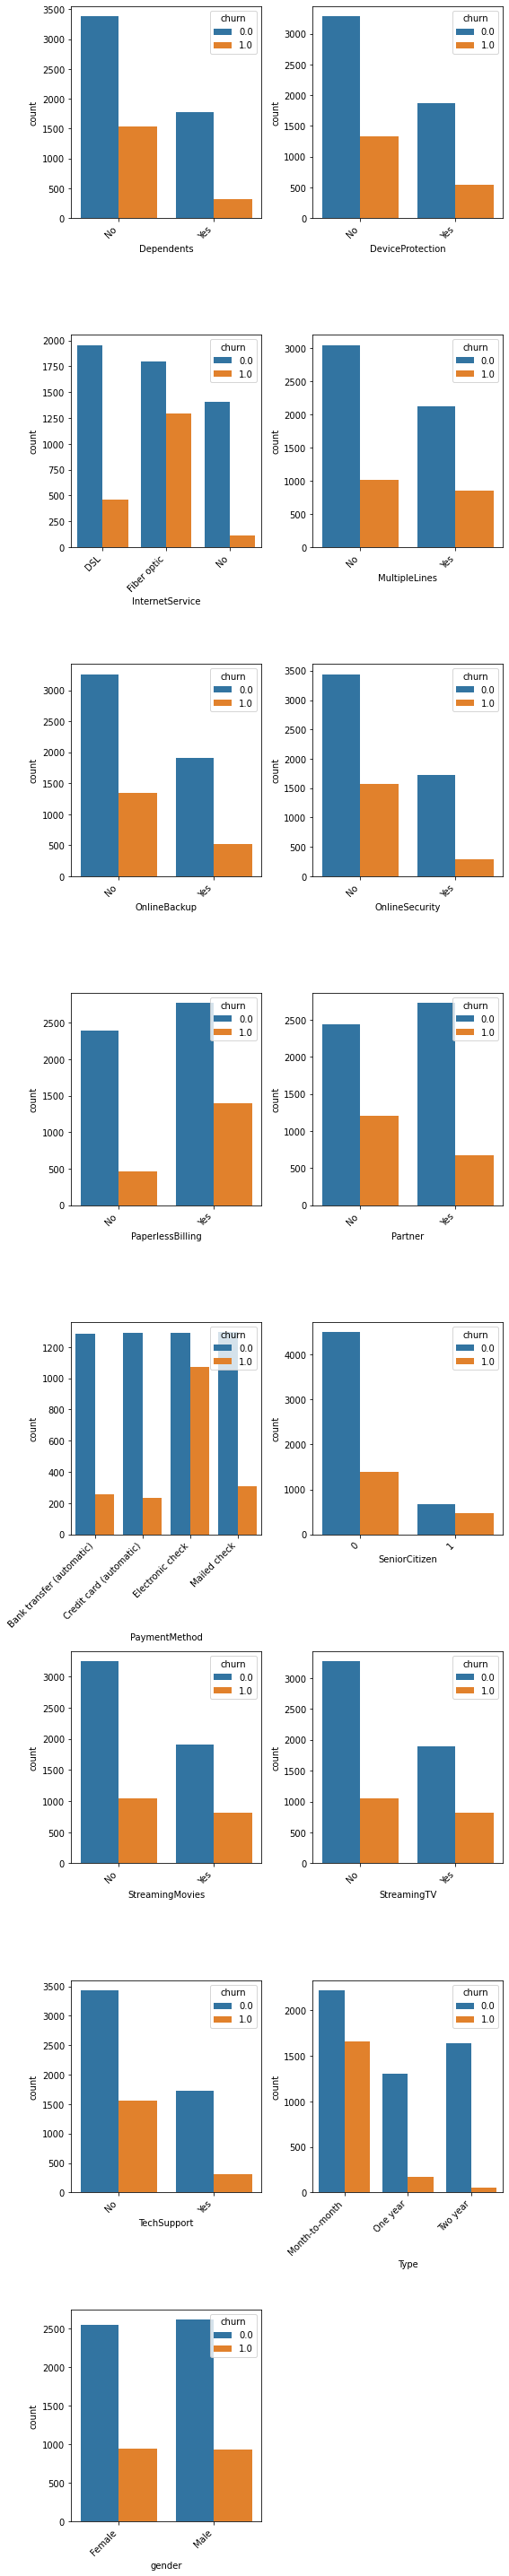

In [41]:
plot_churn_distribution(data_final, 'churn', exclude_cols=['customerID'])

From the histogram above we conclude that clients who left were:
- Month to month payer
- Not senior citizens
- Didn't have one or more of the services from the internet subscription

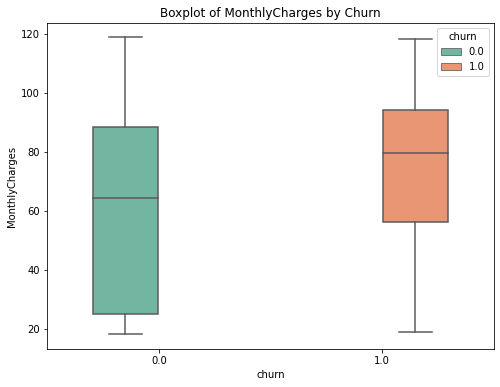

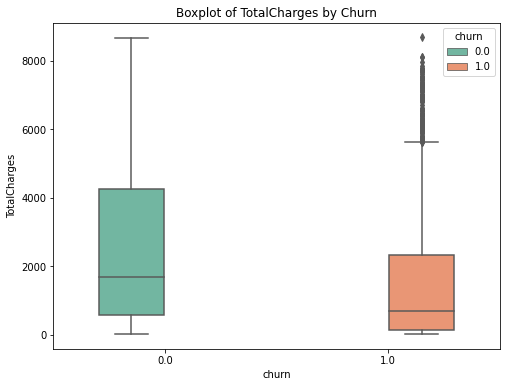

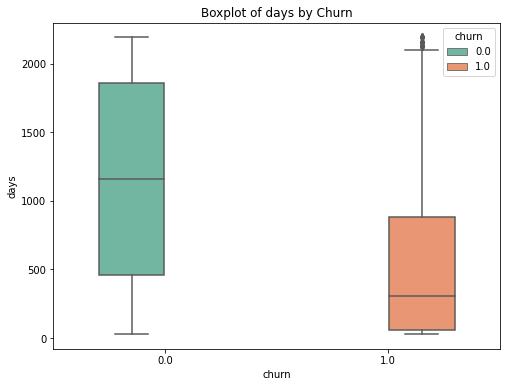

In [42]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='churn', y='MonthlyCharges', data=data_final, hue='churn', palette='Set2', width=0.6)
plt.title('Boxplot of MonthlyCharges by Churn')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='churn', y='TotalCharges', data=data_final, hue='churn', palette='Set2', width=0.6)
plt.title('Boxplot of TotalCharges by Churn')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='churn', y='days', data=data_final, hue='churn', palette='Set2', width=0.6)
plt.title('Boxplot of days by Churn')
plt.show()

From the histogram above we conclude that clients who left were:
- average payment 80 USD (monthly)
- total charges also less than the client who stay
- new user because the days is not long term (based on the boxplot)

**Correlation Matriks**

In [43]:
data_final.corr()

,MonthlyCharges,TotalCharges,churn,days
MonthlyCharges,1.000000,0.651065,0.192858,0.246715
TotalCharges,0.651065,1.000000,-0.199484,0.825811
churn,0.192858,-0.199484,1.000000,-0.354496
days,0.246715,0.825811,-0.354496,1.000000


Strong correlation exists between the number of days and the total charges paid.

**Phone Users**

Now, we have to filter data_final to know the client as phone users.

In [44]:
phone_clients = data_final[data_final['customerID'].isin(phone['customerID'])]
phone_clients.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No,DSL,Yes,Yes,No,No,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Female,0,No,No,Month-to-month,Yes,Electronic check,99.65,820.50,1.0,245.0,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Male,0,No,Yes,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0.0,671.0,Yes,Fiber optic,No,Yes,No,No,Yes,No


In [45]:
phone_clients.describe()

,MonthlyCharges,TotalCharges,churn,days
count,6352.000000,6352.000000,6352.000000,6352.000000
mean,67.239625,2367.108588,0.267475,989.463476
std,30.438439,2328.828347,0.442677,748.275958
min,18.250000,18.800000,0.000000,30.000000
25%,44.787500,415.325000,0.000000,275.000000
50%,74.700000,1422.075000,0.000000,883.000000
75%,91.250000,4025.800000,1.000000,1706.000000
max,118.750000,8684.800000,1.000000,2191.000000


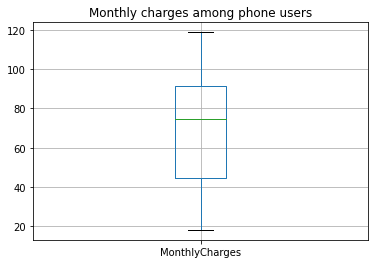

In [46]:
phone_clients.boxplot(column='MonthlyCharges')
plt.title('Monthly charges among phone users')
plt.show()

The median is about 74 USD per month and the average is about 64 USD.

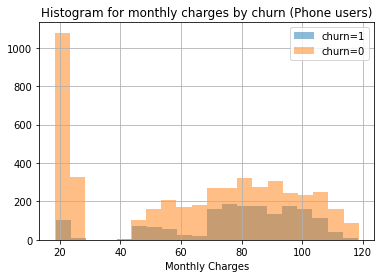

In [47]:
phone_clients[phone_clients['churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
phone_clients[phone_clients['churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('Histogram for monthly charges by churn (Phone users)')
plt.show()

The client who left is smaller

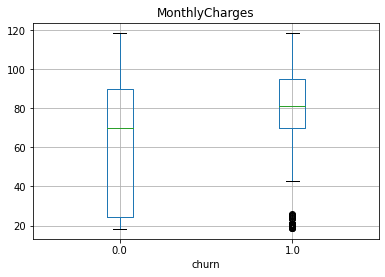

In [48]:
phone_clients.boxplot(column='MonthlyCharges', by='churn')
plt.suptitle('')
plt.show()

The clients who left spent about 80 USD, which is higher than the clients who stayed.

**Internet Service**

In [49]:
internet_clients = data_final[data_final['customerID'].isin(internet['customerID'])]
internet_clients.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No,Fiber optic,No,No,No,No,No,No


In [50]:
internet_clients['MonthlyCharges'].describe()

count    5512.000000
mean       76.855053
std        21.929331
min        23.450000
25%        59.950000
50%        79.500000
75%        94.450000
max       118.750000
Name: MonthlyCharges, dtype: float64

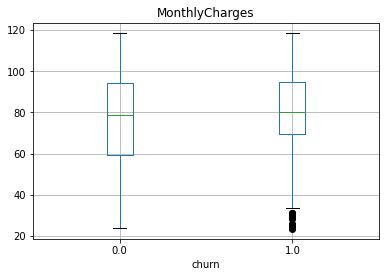

In [51]:
internet_clients.boxplot(column='MonthlyCharges', by='churn')
plt.suptitle('')
plt.show()

The clients spent 80 USD who left and didn't leave also a bit less 80 USD.

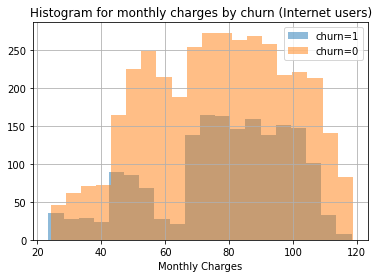

In [52]:
internet_clients[internet_clients['churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
internet_clients[internet_clients['churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('Histogram for monthly charges by churn (Internet users)')
plt.show()

The histogram above, we can see the histogram of clients left and stayed. The distribution a bit similar.

Then we check the information of clients who left and didn't leave.

In [53]:
internet_clients[internet_clients['churn']==1]['MonthlyCharges'].describe()

count    1756.000000
mean       77.920985
std        21.144147
min        23.450000
25%        69.350000
50%        80.450000
75%        94.650000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [54]:
internet_clients[internet_clients['churn']==0]['MonthlyCharges'].describe()

count    3756.000000
mean       76.356709
std        22.272199
min        24.150000
25%        59.137500
50%        78.725000
75%        94.312500
max       118.750000
Name: MonthlyCharges, dtype: float64

If we compare the monthly charges of clients who left and stayed, we got the average of spent in a month is a bit similar (76-77 USD). If we see from histogram, montly charges around 80 USD mostly exists (including churn=1 or churn=0).

# Model Training

Due to imbalanced exist, so we have to upsample.

In [55]:
#Upsampling
def upsample(features, target, repeat):
#creates a function called upsample which takes features, target, and repeat number as arguments
    features_zeros = features[target == 0]#gets the negative class features
    features_ones = features[target == 1]#gets the positive class features 
    target_zeros = target[target == 0]#gets the negative class of the target
    target_ones = target[target == 1]#gets the positive class of the target
    features_ups = pd.concat([features_zeros] + [features_ones] * repeat)
    #upsamples the features by combining the negative class features and the repeated positive class features
    target_ups = pd.concat([target_zeros] + [target_ones] * repeat)
    #upsamples the target by combining the negative class target and the repeated positive class target
    features_ups, target_ups = shuffle(features_ups, target_ups, random_state=12345)
    #shuffles the resulting upsampled features and targets
    return features_ups, target_ups # returns the resulting upsampled features and target

Now, we can drop the column of 'CustomerID' because no any use.

In [56]:
data_final = data_final.drop('customerID', axis=1)

In [57]:
#Convert the data type to be integer
data_final['churn'] = data_final['churn'].astype('int')

- **Ordinal Encoding and Scaling**

In [58]:
data_ord=data_final.copy()
cat_feat = data_ord.columns[data_ord.dtypes=='category']
encoder=OrdinalEncoder()
data_ord[cat_feat]=encoder.fit_transform(data_ord[cat_feat])#encodes the columns
data_ord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   float64
 1   SeniorCitizen     7032 non-null   float64
 2   Partner           7032 non-null   float64
 3   Dependents        7032 non-null   float64
 4   Type              7032 non-null   float64
 5   PaperlessBilling  7032 non-null   float64
 6   PaymentMethod     7032 non-null   float64
 7   MonthlyCharges    7032 non-null   float64
 8   TotalCharges      7032 non-null   float64
 9   churn             7032 non-null   int64  
 10  days              7032 non-null   float64
 11  MultipleLines     7032 non-null   float64
 12  InternetService   7032 non-null   float64
 13  OnlineSecurity    7032 non-null   float64
 14  OnlineBackup      7032 non-null   float64
 15  DeviceProtection  7032 non-null   float64
 16  TechSupport       7032 non-null   float64


In [59]:
#Check the data after encoder
data_ord.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,29.85,29.85,0,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,1889.50,0,1036.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,108.15,1,61.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,42.30,1840.75,0,1371.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,151.65,1,61.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we split the data into feature and target.

In [60]:
features=data_ord.drop('churn', axis=1)
target=data_ord['churn']
features_train, features_test, target_train, target_test=train_test_split(features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5274, 18)
(5274,)
(1758, 18)
(1758,)


In [61]:
#Check the imbalance
target_train.value_counts()

0    3870
1    1404
Name: churn, dtype: int64

In [62]:
#Check the imbalance
target_train.value_counts(normalize=True)

0    0.733788
1    0.266212
Name: churn, dtype: float64

Upsampling the feature and target using the function that we have made.

In [63]:
feat_ups, targ_ups = upsample(features_train, target_train, 3) #repeat value 3
print(feat_ups.shape)
print(targ_ups.shape)

(8082, 18)
(8082,)


The next step is scalling the numeric column.

In [64]:
numeric = ['MonthlyCharges', 'TotalCharges', 'days']

scaler = StandardScaler()
scaler.fit(feat_ups[numeric])
feat_ups[numeric] = scaler.transform(feat_ups[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
feat_ups.head()

/tmp/ipykernel_27/558184720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric] = scaler.transform(features_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1616,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.637200,0.452304,0.305534,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5677,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.591817,-0.702195,-0.896508,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
6137,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.092781,0.150571,-0.108351,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1681,0.0,0.0,1.0,1.0,0.0,1.0,2.0,-0.284435,-0.193608,-0.067372,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6142,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.097834,-0.624962,-0.774938,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


- **One Hot Encoding and Scaling**

In [65]:
data_ohe=pd.get_dummies(data_final, drop_first=True)
data_ohe.head()

,MonthlyCharges,TotalCharges,churn,days,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,29.85,29.85,0,31.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,56.95,1889.50,0,1036.0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,61.0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
3,42.30,1840.75,0,1371.0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0
4,70.70,151.65,1,61.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [66]:
features=data_ohe.drop('churn', axis=1)
target=data_ohe['churn']
f_train, f_test, t_train, t_test=train_test_split(features, target, test_size=0.25, random_state=12345)

print(f_train.shape)
print(t_train.shape)
print(f_test.shape)
print(t_test.shape)

(5274, 22)
(5274,)
(1758, 22)
(1758,)


Now, we upsample the data.

In [67]:
f_ohe, t_ohe = upsample(f_train, t_train, 3)
print(f_ohe.shape, t_ohe.shape)

(8082, 22) (8082,)


Scaling the numeric column.

In [68]:
numeric = ['MonthlyCharges', 'TotalCharges', 'days']

scaler = StandardScaler()
scaler.fit(f_ohe[numeric])
f_ohe[numeric] = scaler.transform(f_ohe[numeric])
f_test[numeric] = scaler.transform(f_test[numeric])
f_ohe.head()

/tmp/ipykernel_27/3871300987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_test[numeric] = scaler.transform(f_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,MonthlyCharges,TotalCharges,days,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
1616,0.637200,0.452304,0.305534,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,1,0
5677,0.591817,-0.702195,-0.896508,1,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
6137,1.092781,0.150571,-0.108351,0,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,1
1681,-0.284435,-0.193608,-0.067372,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
6142,0.097834,-0.624962,-0.774938,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


- **Scaling No Encoding (for Catboost and LightGBM)**

In [69]:
no_enc=data_final.copy()
feat=no_enc.drop('churn', axis=1)
target=no_enc['churn']
ft_train, ft_test, tr_train, tr_test=train_test_split(feat, target,test_size=0.25,random_state=12345)

print(ft_train.shape)
print(tr_train.shape)
print(ft_test.shape)
print(tr_test.shape)

(5274, 18)
(5274,)
(1758, 18)
(1758,)


Upsampling our data above.

In [70]:
f_no_enc, t_no_enc = upsample(ft_train, tr_train, 3)
print(f_no_enc.shape, t_no_enc.shape)

(8082, 18) (8082,)


Scaling the numeric column.

In [71]:
numeric = ['MonthlyCharges', 'TotalCharges', 'days']

scaler = StandardScaler()
scaler.fit(f_no_enc[numeric])
f_no_enc[numeric] = scaler.transform(f_no_enc[numeric])
ft_test[numeric] = scaler.transform(ft_test[numeric])
f_no_enc.head()

/tmp/ipykernel_27/1233301586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_test[numeric] = scaler.transform(ft_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1616,Female,0,No,No,Month-to-month,Yes,Electronic check,0.637200,0.452304,0.305534,Yes,Fiber optic,No,No,No,No,Yes,No
5677,Male,1,No,No,Month-to-month,Yes,Bank transfer (automatic),0.591817,-0.702195,-0.896508,No,Fiber optic,Yes,No,No,No,Yes,No
6137,Female,0,No,No,Month-to-month,Yes,Electronic check,1.092781,0.150571,-0.108351,No,Fiber optic,No,Yes,Yes,No,Yes,Yes
1681,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,-0.284435,-0.193608,-0.067372,Yes,DSL,No,Yes,No,Yes,No,No
6142,Female,0,No,No,Month-to-month,No,Electronic check,0.097834,-0.624962,-0.774938,No,Fiber optic,No,No,No,No,No,No


### MODEL MACHINE LEARNING

- **Logistic Regression**

Training Logistic Regression on Ordinal Encoding

In [72]:
lr = LogisticRegression(solver='liblinear')
lr_score=cross_val_score(lr, feat_ups, targ_ups, scoring='roc_auc', cv=5)
print(lr_score.mean())

0.836839486424871


Training Logistic Regression on One Hot Encoding

In [73]:
lr = LogisticRegression(solver='liblinear')
lr_score=cross_val_score(lr, f_ohe, t_ohe, scoring='roc_auc', cv=5)
print(lr_score.mean())

0.8442112783213371


- **Random Forest**

Training Random Forest on Ordinal Encoding

In [74]:
for depth in range(15, 26):
    rf=RandomForestClassifier(n_estimators=30, max_depth=depth, random_state=12345)
    rf_score=cross_val_score(rf, feat_ups, targ_ups, scoring='roc_auc', cv=5)
    print('Max_depth', depth, 'score:', rf_score.mean())

Max_depth 15 score: 0.971180908651817
Max_depth 16 score: 0.9741557040868777
Max_depth 17 score: 0.9758066927425764
Max_depth 18 score: 0.977822664847077
Max_depth 19 score: 0.9770211427497738
Max_depth 20 score: 0.9778856046709155
Max_depth 21 score: 0.9783072043829044
Max_depth 22 score: 0.9784017587336399
Max_depth 23 score: 0.9776998311239259
Max_depth 24 score: 0.9782535208277349
Max_depth 25 score: 0.9782598982663393


Training Random Forest on One Hot Encoding

In [75]:
for depth in range(15, 26):
    rf=RandomForestClassifier(n_estimators=40, max_depth=depth, random_state=12345)
    rf_score=cross_val_score(rf, f_ohe, t_ohe, scoring='roc_auc', cv=5)
    print('Max_depth', depth, 'score:', rf_score.mean())

Max_depth 15 score: 0.9704177820585995
Max_depth 16 score: 0.9748960869032738
Max_depth 17 score: 0.9757125060724638
Max_depth 18 score: 0.9768150819693711
Max_depth 19 score: 0.9768592593422605
Max_depth 20 score: 0.9776877682871763
Max_depth 21 score: 0.9781700948225028
Max_depth 22 score: 0.9784966434508752
Max_depth 23 score: 0.9779276846260739
Max_depth 24 score: 0.9777353454316857
Max_depth 25 score: 0.9781898349034643


- **Catboost**

Training Catboost on Ordinal Encoding

In [76]:
cb=CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb_score=cross_val_score(cb, feat_ups, targ_ups, scoring='roc_auc', cv=5)

0:	learn: 0.6413112	total: 52ms	remaining: 52s
1:	learn: 0.6087988	total: 56.1ms	remaining: 28s
2:	learn: 0.5821230	total: 60.6ms	remaining: 20.1s
3:	learn: 0.5630570	total: 64.6ms	remaining: 16.1s
4:	learn: 0.5468344	total: 68.9ms	remaining: 13.7s
5:	learn: 0.5319885	total: 73ms	remaining: 12.1s
6:	learn: 0.5192381	total: 77.2ms	remaining: 11s
7:	learn: 0.5097643	total: 81.6ms	remaining: 10.1s
8:	learn: 0.5025755	total: 85.9ms	remaining: 9.46s
9:	learn: 0.4934332	total: 90.3ms	remaining: 8.94s
10:	learn: 0.4875530	total: 94.3ms	remaining: 8.48s
11:	learn: 0.4823530	total: 98.7ms	remaining: 8.13s
12:	learn: 0.4783209	total: 103ms	remaining: 7.8s
13:	learn: 0.4719718	total: 107ms	remaining: 7.53s
14:	learn: 0.4659346	total: 111ms	remaining: 7.31s
15:	learn: 0.4619396	total: 115ms	remaining: 7.1s
16:	learn: 0.4587881	total: 120ms	remaining: 6.92s
17:	learn: 0.4544669	total: 124ms	remaining: 6.76s
18:	learn: 0.4520183	total: 128ms	remaining: 6.6s
19:	learn: 0.4488612	total: 132ms	remainin

In [77]:
print(cb_score.mean())

0.9805835531608407


Training Catboost on One Hot Encoding

In [78]:
cb=CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb_score=cross_val_score(cb, f_ohe, t_ohe, scoring='roc_auc', cv=5)

0:	learn: 0.6482738	total: 4.72ms	remaining: 4.72s
1:	learn: 0.6149457	total: 9.26ms	remaining: 4.62s
2:	learn: 0.5866526	total: 13.9ms	remaining: 4.62s
3:	learn: 0.5625236	total: 18.4ms	remaining: 4.57s
4:	learn: 0.5457310	total: 23.2ms	remaining: 4.62s
5:	learn: 0.5298494	total: 28ms	remaining: 4.64s
6:	learn: 0.5185605	total: 33.1ms	remaining: 4.69s
7:	learn: 0.5054530	total: 37.9ms	remaining: 4.7s
8:	learn: 0.4987319	total: 42.7ms	remaining: 4.7s
9:	learn: 0.4923483	total: 47.5ms	remaining: 4.7s
10:	learn: 0.4846324	total: 52.1ms	remaining: 4.68s
11:	learn: 0.4779523	total: 56.9ms	remaining: 4.68s
12:	learn: 0.4737210	total: 61.3ms	remaining: 4.66s
13:	learn: 0.4702890	total: 66.2ms	remaining: 4.66s
14:	learn: 0.4662185	total: 70.9ms	remaining: 4.65s
15:	learn: 0.4623550	total: 75.5ms	remaining: 4.64s
16:	learn: 0.4599090	total: 80ms	remaining: 4.63s
17:	learn: 0.4567670	total: 84.5ms	remaining: 4.61s
18:	learn: 0.4532120	total: 89.2ms	remaining: 4.61s
19:	learn: 0.4516520	total: 9

In [79]:
print(cb_score.mean())

0.9795043681222474


Training Catboost on data without Encoding

In [80]:
cat_feat=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner',
'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender']
cb=CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb.fit(f_no_enc, t_no_enc, cat_features=cat_feat, verbose=False, plot=False)
cb_score = cross_val_score(cb, feat_ups, targ_ups, scoring='roc_auc', cv=5)

0:	learn: 0.6413112	total: 4.16ms	remaining: 4.16s
1:	learn: 0.6087988	total: 8.54ms	remaining: 4.26s
2:	learn: 0.5821230	total: 12.6ms	remaining: 4.19s
3:	learn: 0.5630570	total: 17ms	remaining: 4.22s
4:	learn: 0.5468344	total: 21.1ms	remaining: 4.19s
5:	learn: 0.5319885	total: 25.2ms	remaining: 4.18s
6:	learn: 0.5192381	total: 29.6ms	remaining: 4.2s
7:	learn: 0.5097643	total: 33.8ms	remaining: 4.19s
8:	learn: 0.5025755	total: 38.5ms	remaining: 4.24s
9:	learn: 0.4934332	total: 42.6ms	remaining: 4.22s
10:	learn: 0.4875530	total: 46.8ms	remaining: 4.21s
11:	learn: 0.4823530	total: 51.1ms	remaining: 4.21s
12:	learn: 0.4783209	total: 55ms	remaining: 4.18s
13:	learn: 0.4719718	total: 59.4ms	remaining: 4.18s
14:	learn: 0.4659346	total: 63.6ms	remaining: 4.17s
15:	learn: 0.4619396	total: 68.3ms	remaining: 4.2s
16:	learn: 0.4587881	total: 77.2ms	remaining: 4.46s
17:	learn: 0.4544669	total: 82.2ms	remaining: 4.48s
18:	learn: 0.4520183	total: 87.7ms	remaining: 4.53s
19:	learn: 0.4488612	total: 

In [85]:
print(cb_score.mean())

0.9805835531608407


- **LightGBM**

Training LGBM on Ordinal Encoding

In [86]:
lgbm=LGBMClassifier(objective='binary',
                    learning_rate= 0.7,
                    random_state=12345)
lgbm_score=cross_val_score(lgbm, feat_ups, targ_ups, scoring='roc_auc', cv=5)
print(lgbm_score.mean())

0.9803304521952538


Training LGBM on One Hot Encoding

In [88]:
lgbm=LGBMClassifier(objective='binary',
                    learning_rate= 0.7,
                    random_state=12345)
lgbm_score=cross_val_score(lgbm, f_ohe, t_ohe, scoring='roc_auc', cv=5)
print(lgbm_score.mean())

0.9790392102697842


Training LGBM on data without Encoding

In [89]:
lgbm=LGBMClassifier(objective='binary',
                    learning_rate= 0.7,
                    random_state=12345)
lgbm_score=cross_val_score(lgbm, f_no_enc, t_no_enc, scoring='roc_auc', cv=5)
print(lgbm_score.mean())

0.9793247077206619


### Final Testing

In [90]:
#Training CatBoost on data that was scaled but not encoded
cat_feat=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod']
cb=CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb.fit(f_no_enc, t_no_enc, cat_features=cat_feat, verbose=False, plot=False)
pred=cb.predict(ft_test)
acc=accuracy_score(tr_test, pred)
probab=cb.predict_proba(ft_test)
auc=roc_auc_score(tr_test, probab[:,1])
print('AUC-ROC =', auc)
print('Accuracy =', acc)

AUC-ROC = 0.9161032524178995
Accuracy = 0.8646188850967008


# Conclusion

We have the data about communication, first we have to do the preprocessing and analysis EDA. From there we found:
- The columns must be converted to category and float.
- The data doesn't have duplicates.
- There is imbalance class of 'Churn' which is stayed more than didn't left.
- From the histogram shows that clients who left were month to month payer, not senior citizens, didn't have one or more of the services from the internet subscription.
- If we compare the monthly charges of clients who left and stayed, we got the average of spent in a month is a bit similar (76-77 USD). If we see from histogram, montly charges around 80 USD mostly exists (including churn=1 or churn=0).

After that, we did the Model Training.
- We have to make 3 datas: Ordinal Encoding and Scaling, One Hot Encoding and Scaling, and Without Encoding.
- Then did the training using Logistic Regression, Random Forest, Decision Tree, Catboost, and LightGBM.
- From the training we got the best score is Catboost. Then we did testing and got the AUC-ROC 0.91 and accuracy 0.86